In [16]:
from mpi4py import MPI
from dolfinx import mesh
from dolfinx import fem
from dolfinx import cpp
import numpy as np
import ufl
from petsc4py import PETSc

[inf inf inf inf inf inf inf inf inf inf inf]


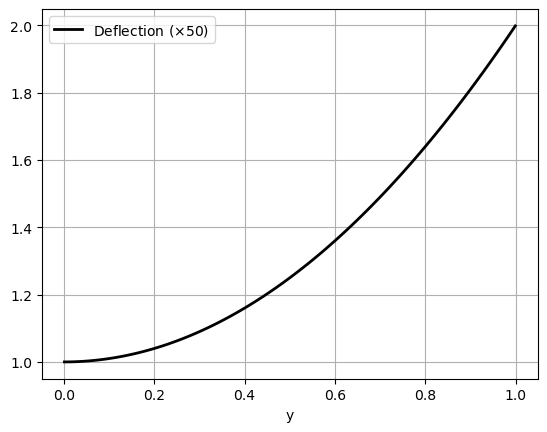

In [17]:
#domain = mesh.create_unit_square(MPI.COMM_WORLD, 3, 3,mesh.CellType.triangle)
domain = mesh.create_interval(MPI.COMM_WORLD,10,(0,1))
V = fem.FunctionSpace(domain, ("CG", 1))
V2 = fem.FunctionSpace(domain,("CG",2))
f = fem.Function(V2)
f.interpolate(lambda x: 1 + x[0]**2)# + 2 * x[1]**2)
#see if we can finesse using L2 projection
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = f.dx(0)*v*ufl.dx
problem = fem.petsc.LinearProblem(a, L, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()
print(uh.vector.getArray())
#f.interpolate(f.dx(0))


points = np.zeros((3, 101))
tol = 0.001
x = np.linspace(0 + tol, 1 - tol, 101)
points[0] = x
u_values = []
p_values = []
from dolfinx import geometry
bb_tree = geometry.BoundingBoxTree(domain, domain.topology.dim)
cells = []
points_on_proc = []
# Find cells whose bounding-box collide with the the points
cell_candidates = geometry.compute_collisions(bb_tree, points.T)
# Choose one of the cells that contains the point
colliding_cells = geometry.compute_colliding_cells(domain, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i))>0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])
points_on_proc = np.array(points_on_proc, dtype=np.float64)
f_values = f.eval(points_on_proc, cells)
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(points_on_proc[:,0], f_values, "k", linewidth=2, label="Deflection ($\\times 50$)")
#plt.plot(points_on_proc[:, 1], p_values, "b--", linewidth = 2, label="Load")
plt.grid(True)
plt.xlabel("y")
plt.legend()

In [23]:
A_PETSc = problem.A
pc2 = PETSc.PC().create()
#this is a direct solve with lu
pc2.setType('bjacobi')
pc2.setOperators(A_PETSc)

ksp2 = PETSc.KSP().create() # creating a KSP object named ksp
ksp2.setOperators(A_PETSc)
ksp2.setType('gmres')
ksp2.setPC(pc2)
print(dir(pc2))

['ASMType', 'CompositeType', 'GAMGType', 'GASMType', 'HPDDMCoarseCorrectionType', 'MGCycleType', 'MGType', 'PatchConstructType', 'SchurFactType', 'SchurPreType', 'Side', 'Type', '__bool__', '__call__', '__class__', '__copy__', '__deepcopy__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__pyx_vtable__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'addCompositePCType', 'appendOptionsPrefix', 'apply', 'applySymmetricLeft', 'applySymmetricRight', 'applyTranspose', 'classid', 'comm', 'compose', 'create', 'createPython', 'decRef', 'destroy', 'fortran', 'getASMSubKSP', 'getAttr', 'getClassId', 'getClassName', 'getComm', 'getCompositePC', 'getDM', 'getDict', 'getFactorMatrix', 'getFactorSolverType', 'getFieldSplitSchurGetSubKSP', 'getFieldSplitSubKSP', 'getHPDDMCoarseCorrectionType', 'getHPDDMS